### Created on 2025
### @author: S.W

## Deep Q-Network (DQN)
DQN의 핵심 아이디어:
- Q-함수를 신경망으로 근사
- Experience Replay로 효율적 학습
- Target Network로 학습 안정화
- 이산 행동 공간에서 강력한 성능

### 라이브러리 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import deque, namedtuple
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cuda


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


### 실습: CartPole-v1

In [2]:
# 간단한 CartPole 환경 구현 (gym 의존성 제거)
class CartPoleEnv:
   """
   간단한 CartPole 환경 구현
   
   카트 위에 막대가 있고, 카트를 좌우로 움직여서 막대가 넘어지지 않도록 하는 환경.
   물리 법칙을 따라 카트와 막대의 움직임을 시뮬레이션합니다.
   """
   
   def __init__(self):
       """
       CartPole 환경 초기화
       
       물리적 파라미터들과 임계값들을 설정합니다.
       """
       # 물리 파라미터들
       self.gravity = 9.8              # 중력 가속도 (m/s^2)
       self.masscart = 1.0             # 카트의 질량 (kg)
       self.masspole = 0.1             # 막대의 질량 (kg)
       self.total_mass = (self.masspole + self.masscart)  # 전체 질량
       self.length = 0.5               # 막대의 절반 길이 (m) - 회전 중심에서 질량 중심까지
       self.polemass_length = (self.masspole * self.length)  # 막대 질량 × 길이
       self.force_mag = 10.0           # 카트에 가해지는 힘의 크기 (N)
       self.tau = 0.02                 # 시간 간격 (초) - 물리 시뮬레이션 스텝 크기
       
       # 게임 오버 임계값들
       self.theta_threshold_radians = 12 * 2 * np.pi / 360  # ±12도를 라디안으로 변환
       self.x_threshold = 2.4          # 카트가 중심에서 ±2.4m 이상 벗어나면 게임 오버
       
       # 상태와 행동 공간 정의 (OpenAI Gym 스타일)
       self.observation_space = type('obj', (object,), {'shape': (4,)})()  # 4차원 상태 공간
       self.action_space = type('obj', (object,), {'n': 2})()              # 2개의 이산 행동
       
       # 현재 상태 변수
       self.state = None
       self.reset()
   
   def reset(self):
       """
       환경을 초기 상태로 리셋
       
       Returns:
           np.ndarray: 초기 상태 [x, x_dot, theta, theta_dot]
               - x: 카트의 위치 (-0.05 ~ 0.05)
               - x_dot: 카트의 속도 (-0.05 ~ 0.05)  
               - theta: 막대의 각도 (-0.05 ~ 0.05 라디안)
               - theta_dot: 막대의 각속도 (-0.05 ~ 0.05 라디안/초)
       """
       self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
       return self.state.copy()
   
   def step(self, action):
       """
       주어진 행동을 수행하고 환경을 한 스텝 진행
       
       Args:
           action (int): 수행할 행동
               - 0: 왼쪽으로 힘을 가함 (-10N)
               - 1: 오른쪽으로 힘을 가함 (+10N)
       
       Returns:
           tuple: (next_state, reward, done, info)
               - next_state (np.ndarray): 다음 상태 [x, x_dot, theta, theta_dot]
               - reward (float): 보상 (생존 시 1.0, 게임오버 시 0.0)
               - done (bool): 에피소드 종료 여부
               - info (dict): 추가 정보 (비어있음)
       """
       assert action in [0, 1], f"Invalid action {action}"
       
       # 현재 상태 분해
       x, x_dot, theta, theta_dot = self.state
       
       # 행동에 따른 힘 설정
       force = self.force_mag if action == 1 else -self.force_mag
       
       # 삼각함수 미리 계산 (성능 향상)
       costheta = np.cos(theta)
       sintheta = np.sin(theta)
       
       # 물리 법칙에 따른 가속도 계산
       # 복합 시스템의 운동방정식을 풀어서 얻은 공식들
       temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
       
       # 막대의 각가속도 계산
       thetaacc = (self.gravity * sintheta - costheta * temp) / (
           self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass)
       )
       
       # 카트의 가속도 계산
       xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
       
       # 오일러 적분법으로 상태 업데이트
       # v = v0 + a*dt, x = x0 + v*dt
       x = x + self.tau * x_dot
       x_dot = x_dot + self.tau * xacc
       theta = theta + self.tau * theta_dot
       theta_dot = theta_dot + self.tau * thetaacc
       
       # 새로운 상태 저장
       self.state = np.array([x, x_dot, theta, theta_dot])
       
       # 게임 오버 조건 확인
       done = bool(
           x < -self.x_threshold           # 카트가 너무 왼쪽으로
           or x > self.x_threshold         # 카트가 너무 오른쪽으로
           or theta < -self.theta_threshold_radians  # 막대가 너무 왼쪽으로 기울어짐
           or theta > self.theta_threshold_radians   # 막대가 너무 오른쪽으로 기울어짐
       )
       
       # 보상 계산: 생존하면 1점, 게임오버면 0점
       reward = 1.0 if not done else 0.0
       
       return self.state.copy(), reward, done, {}

# 환경 생성 및 정보 출력
env = CartPoleEnv()
print("✓ CartPole 환경 생성 완료")
print(f"상태 공간 차원: {env.observation_space.shape}")
print(f"행동 공간 크기: {env.action_space.n}")
print("상태: [위치, 속도, 각도, 각속도]")
print("행동: [왼쪽(0), 오른쪽(1)]")
print("목표: 막대를 넘어뜨리지 않고 최대한 오래 유지")

# 환경 동작 테스트
print("\n환경 테스트:")
test_state = env.reset()
print(f"초기 상태: {test_state}")
test_next_state, test_reward, test_done, _ = env.step(1)  # 오른쪽으로 힘을 가함
print(f"한 스텝 후 상태: {test_next_state}")
print(f"보상: {test_reward}, 종료: {test_done}")

✓ CartPole 환경 생성 완료
상태 공간 차원: (4,)
행동 공간 크기: 2
상태: [위치, 속도, 각도, 각속도]
행동: [왼쪽(0), 오른쪽(1)]
목표: 막대를 넘어뜨리지 않고 최대한 오래 유지

환경 테스트:
초기 상태: [ 0.00012083 -0.04928657  0.00482148 -0.01618342]
한 스텝 후 상태: [-0.00086491  0.1457659   0.00449781 -0.30734122]
보상: 1.0, 종료: False


### 시각화 라이브러리 불러오기

In [3]:
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
from IPython.display import HTML, display

# GIF 스타일 설정
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 80

### DQN 알고리즘 및 Replay Buffer 정의

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque, namedtuple

class DQN(nn.Module):
    """
    Deep Q-Network: 상태를 입력받아 각 행동의 Q값을 출력하는 신경망
    
    강화학습에서 Q함수를 근사하는 신경망입니다.
    상태를 입력으로 받아서 각 행동의 Q값(미래 누적 보상의 기댓값)을 출력합니다.
    """
    
    def __init__(self, state_size, action_size, hidden_size=128):
        """
        DQN 신경망 초기화
        
        Args:
            state_size (int): 입력 상태의 차원 (CartPole의 경우 4)
            action_size (int): 가능한 행동의 개수 (CartPole의 경우 2)
            hidden_size (int): 은닉층의 뉴런 개수 (기본값: 128)
        """
        super(DQN, self).__init__()
        # 3층 완전연결 네트워크 구성
        self.fc1 = nn.Linear(state_size, hidden_size)    # 입력층 → 은닉층1
        self.fc2 = nn.Linear(hidden_size, hidden_size)   # 은닉층1 → 은닉층2
        self.fc3 = nn.Linear(hidden_size, action_size)   # 은닉층2 → 출력층
        
    def forward(self, state):
        """
        순전파: 상태를 입력받아 Q값을 계산
        
        Args:
            state (torch.Tensor): 현재 상태 [batch_size, state_size]
            
        Returns:
            torch.Tensor: 각 행동의 Q값 [batch_size, action_size]
        """
        x = F.relu(self.fc1(state))                      # ReLU 활성화로 비선형성 추가
        x = F.relu(self.fc2(x))                          # ReLU 활성화로 비선형성 추가
        q_values = self.fc3(x)                           # 선형 출력 (Q값은 음수도 가능)
        return q_values


# 경험(Experience) 정의: 하나의 전이(transition)를 저장하는 구조
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    """
    경험 재생 버퍼: 과거 경험들을 저장하고 무작위 샘플링하는 메모리
    
    DQN에서 학습의 안정성을 위해 사용하는 중요한 구성요소입니다.
    연속된 경험들 간의 상관관계를 줄여서 학습을 안정화시킵니다.
    """
    
    def __init__(self, capacity=10000):
        """
        경험 재생 버퍼 초기화
        
        Args:
            capacity (int): 최대 저장 가능한 경험의 개수
                           용량 초과 시 가장 오래된 경험부터 삭제됨
        """
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        """
        새로운 경험을 버퍼에 추가
        
        Args:
            *args: Experience의 구성요소들 (state, action, reward, next_state, done)
        """
        self.buffer.append(Experience(*args))
    
    def sample(self, batch_size):
        """
        버퍼에서 무작위로 경험들을 샘플링
        
        Args:
            batch_size (int): 샘플링할 경험의 개수
            
        Returns:
            list: 무작위로 선택된 Experience 객체들의 리스트
        """
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        """버퍼에 저장된 경험의 개수 반환"""
        return len(self.buffer)


class ImprovedDQNAgent:
    """
    개선된 DQN 에이전트: Double DQN과 Experience Replay를 사용하는 강화학습 에이전트
    
    Q-learning을 신경망으로 확장한 Deep Q-Network의 개선된 버전입니다.
    안정적인 학습을 위해 타겟 네트워크와 경험 재생을 사용합니다.
    """
    
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        DQN 에이전트 초기화
        
        Args:
            state_size (int): 상태 공간의 차원
            action_size (int): 행동 공간의 크기
            lr (float): 학습률 - 네트워크 가중치 업데이트 속도 조절
            gamma (float): 할인 인수 - 미래 보상의 현재 가치 비율 (0~1)
            epsilon (float): 초기 탐험 확률 - 무작위 행동 선택 비율
            epsilon_decay (float): 탐험 확률 감소율 - 시간이 지날수록 탐험 감소
            epsilon_min (float): 최소 탐험 확률 - 완전히 0이 되지 않도록 제한
        """
        # 기본 설정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr              # 학습률: 너무 크면 불안정, 너무 작으면 학습 느림
        self.gamma = gamma        # 할인 인수: 1에 가까울수록 미래 보상을 중요하게 생각
        self.epsilon = epsilon    # 현재 탐험 확률
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # 신경망 초기화: 메인 네트워크와 타겟 네트워크
        self.q_network = DQN(state_size, action_size).to(self.device)        # 학습되는 메인 네트워크
        self.target_network = DQN(state_size, action_size).to(self.device)   # 안정적인 타겟값 계산용
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # 타겟 네트워크를 메인 네트워크로 초기화
        self.update_target_network()
        
        # 경험 재생 버퍼 초기화
        self.memory = ReplayBuffer(capacity=10000)
        
        # 성능 모니터링용 리스트
        self.episode_rewards = []
        self.losses = []
    
    def update_target_network(self):
        """
        타겟 네트워크를 메인 네트워크의 가중치로 업데이트
        
        DQN에서 학습 안정성을 위해 사용하는 기법입니다.
        타겟 Q값을 계산할 때 고정된 네트워크를 사용하여
        타겟 값이 계속 변하는 것을 방지합니다.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def select_action(self, state, training=True):
        """
        현재 상태에서 epsilon-greedy 정책에 따라 행동 선택
        
        epsilon 확률로 무작위 행동을 선택하여 탐험하고,
        (1-epsilon) 확률로 Q값이 최대인 행동을 선택하여 활용합니다.
        
        Args:
            state (np.ndarray): 현재 환경의 상태
            training (bool): 학습 모드 여부 (False면 항상 최적 행동 선택)
            
        Returns:
            int: 선택된 행동
        """
        # 탐험: epsilon 확률로 무작위 행동 선택
        if training and np.random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        # 활용: Q값이 최대인 행동 선택
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()
    
    def store_experience(self, state, action, reward, next_state, done):
        """
        경험을 경험 재생 버퍼에 저장
        
        Args:
            state (np.ndarray): 현재 상태
            action (int): 수행한 행동
            reward (float): 받은 보상
            next_state (np.ndarray): 다음 상태
            done (bool): 에피소드 종료 여부
        """
        # gymnasium 환경 호환성: 튜플 형태로 오는 경우 처리
        if isinstance(state, tuple):
            state = state[0]
        if isinstance(next_state, tuple):
            next_state = next_state[0]
        
        self.memory.push(state, action, reward, next_state, done)
    
    def train_step(self, batch_size=32):
        """
        경험 재생을 통한 네트워크 학습
        
        DQN의 핵심 학습 과정입니다.
        저장된 경험들에서 무작위로 배치를 샘플링하여
        벨만 방정식을 통해 네트워크를 업데이트합니다.
        
        Args:
            batch_size (int): 한 번에 학습할 경험의 개수
            
        Returns:
            float: 계산된 손실값 (모니터링용)
        """
        if len(self.memory) < batch_size:
            return 0
        
        # 1단계: 경험 배치 샘플링 및 텐서 변환
        experiences = self.memory.sample(batch_size)
        
        states = torch.FloatTensor([e.state for e in experiences]).to(self.device)
        actions = torch.LongTensor([e.action for e in experiences]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(self.device)
        dones = torch.BoolTensor([e.done for e in experiences]).to(self.device)
        
        # 2단계: 현재 Q값 계산 - 실제로 선택한 행동의 Q값
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        
        # 3단계: 타겟 Q값 계산 (Double DQN 방식)
        with torch.no_grad():
            # 메인 네트워크로 다음 상태에서의 최적 행동 선택
            next_actions = self.q_network(next_states).argmax(1)
            # 타겟 네트워크로 선택된 행동의 Q값 계산
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            # 벨만 방정식: Q_target = reward + gamma * Q(next_state, next_action) * (1 - done)
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # 4단계: 손실 계산 및 역전파
        loss = F.mse_loss(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()        # 이전 그래디언트 초기화
        loss.backward()                   # 역전파로 그래디언트 계산
        
        # 그래디언트 클리핑으로 그래디언트 폭발 방지
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        
        self.optimizer.step()             # 계산된 그래디언트로 파라미터 업데이트
        
        # 5단계: 탐험 확률 감소 (시간이 지날수록 탐험 → 활용)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()

### DQN 학습 및 테스트 함수 정의

In [5]:
def train_dqn_agent(env, agent, num_episodes=1000, target_update_freq=100, verbose=True):
    """
    DQN 에이전트를 환경에서 학습시키는 함수
    
    에이전트가 환경과 상호작용하며 경험을 쌓고,
    경험 재생을 통해 Q-네트워크를 학습하는 전체 과정을 관리합니다.
    
    Args:
        env: CartPole 환경 객체
        agent: 학습할 DQN 에이전트
        num_episodes (int): 총 학습 에피소드 수
        target_update_freq (int): 타겟 네트워크 업데이트 주기 (에피소드 단위)
        verbose (bool): 학습 진행 상황 출력 여부
        
    Returns:
        list: 각 에피소드별 총 보상 리스트
    """
    episode_rewards = []
    
    if verbose:
        print(f"Training DQN agent ({num_episodes} episodes)")
        print("=" * 50)
    
    for episode in range(num_episodes):
        # 1단계: 환경 초기화
        state, info = env.reset()  # 최신 Gym API에 맞게 unpack
        done = False
        episode_reward = 0
        step_count = 0
        max_steps = 500
        
        # 2단계: 에피소드 진행 - 환경과 상호작용하며 경험 수집
        while not done and step_count < max_steps:
            # 행동 선택 (epsilon-greedy 정책)
            action = agent.select_action(state, training=True)
            
            # 환경에서 행동 수행 및 결과 관찰
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # 경험을 메모리에 저장 (나중에 학습에 사용)
            agent.store_experience(state, action, reward, next_state, done)
            
            # 네트워크 학습 (충분한 경험이 쌓이면)
            loss = agent.train_step()
            if loss > 0:
                agent.losses.append(loss)
            
            # 상태 업데이트 및 보상 누적
            episode_reward += reward
            state = next_state
            step_count += 1
        
        # 3단계: 에피소드 결과 기록
        episode_rewards.append(episode_reward)
        agent.episode_rewards.append(episode_reward)
        
        # 4단계: 주기적으로 타겟 네트워크 업데이트
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        # 5단계: 학습 진행 상황 출력
        if verbose and (episode + 1) % 100 == 0:
            recent_avg = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Recent 100 avg = {recent_avg:.2f}, epsilon = {agent.epsilon:.3f}")
    
    if verbose:
        final_avg = np.mean(episode_rewards[-100:])
        print(f"Training complete! Final average: {final_avg:.2f}")
    
    return episode_rewards


def test_agent_performance(agent, env, num_tests=10):
    """
    학습된 에이전트의 성능을 평가하는 함수
    
    학습이 완료된 에이전트를 여러 에피소드에서 테스트하여
    평균 성능과 일관성을 측정합니다.
    
    Args:
        agent: 평가할 DQN 에이전트
        env: CartPole 환경 객체
        num_tests (int): 테스트할 에피소드 수
        
    Returns:
        list: 각 테스트 에피소드의 총 보상 리스트
    """
    test_rewards = []
    
    for test in range(num_tests):
        # 1단계: 환경 초기화
        state, info = env.reset()
        done = False
        total_reward = 0
        step = 0
        max_steps = 500
        
        # 2단계: 평가 에피소드 진행 - 학습된 정책으로만 행동
        while not done and step < max_steps:
            # 평가 모드: 항상 최적 행동 선택 (탐험 없음)
            action = agent.select_action(state, training=False)
            
            # 환경에서 행동 수행
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # 상태 업데이트 및 보상 누적 (경험 저장은 하지 않음)
            state = next_state
            total_reward += reward
            step += 1
        
        # 3단계: 테스트 결과 기록
        test_rewards.append(total_reward)
    
    return test_rewards

### CartPole 애니메이션 함수 정의

In [6]:
class CartPoleAnimator:
    """
    CartPole 환경에서 에이전트의 플레이를 애니메이션으로 시각화하는 클래스
    
    학습된 에이전트가 실제로 환경에서 어떻게 행동하는지 시각적으로 확인할 수 있는
    애니메이션을 생성합니다. 카트의 움직임, 막대의 기울어짐, 에이전트의 행동 선택
    등을 실시간으로 보여줍니다.
    """
    
    def __init__(self, title="CartPole", figsize=(10, 6)):
        """
        애니메이터 초기화
        
        Args:
            title (str): 애니메이션 제목
            figsize (tuple): 그림 크기 (가로, 세로)
        """
        self.title = title
        self.figsize = figsize
        
        # 에피소드 데이터 저장소
        self.states = []      # 각 스텝의 환경 상태 [위치, 속도, 각도, 각속도]
        self.actions = []     # 각 스텝에서 에이전트가 선택한 행동 [0: 왼쪽, 1: 오른쪽]
        self.total_reward = 0 # 에피소드 총 보상
        
        # 시각적 요소들 (나중에 초기화)
        self.fig = None       # matplotlib 그림 객체
        self.ax = None        # 그래프 축 객체
        self.cart = None      # 카트 시각 요소
        self.pole_line = None # 막대 시각 요소
        self.pole_tip = None  # 막대 끝 시각 요소
        self.step_text = None # 스텝 정보 텍스트
        self.action_text = None # 행동 정보 텍스트
        self.angle_text = None  # 각도 정보 텍스트
    
    def collect_episode_data(self, agent, env, max_frames=200):
        """
        에이전트가 한 에피소드를 플레이하면서 모든 상태와 행동을 기록
        
        학습된 에이전트가 환경에서 에피소드를 진행하며
        매 스텝의 상태와 행동을 수집하여 애니메이션에 사용할 데이터를 준비합니다.
        
        Args:
            agent: 학습된 에이전트 (DQN 또는 REINFORCE)
            env: CartPole 환경
            max_frames (int): 최대 프레임 수 (에피소드 길이 제한)
        """
        # 데이터 초기화
        self.states = []
        self.actions = []
        self.total_reward = 0
        
        # 에피소드 시작
        state, _ = env.reset()
        done = False
        step = 0
        
        # 에이전트가 에피소드를 플레이하며 데이터 수집
        while not done and step < max_frames:
            # 현재 상태 저장 (애니메이션에서 카트와 막대 위치 계산에 사용)
            self.states.append(np.array(state).copy())
            
            # 에이전트가 현재 상태를 보고 행동 결정 (평가 모드)
            action = agent.select_action(state, training=False)
            
            # 선택한 행동을 환경에서 실행하고 결과 관찰
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # 선택한 행동 기록 (애니메이션에서 행동 표시용)
            self.actions.append(action)
            state = next_state
            self.total_reward += reward
            step += 1
        
        print(f"Animation episode: {len(self.states)} steps, Reward: {self.total_reward}")
    
    def setup_animation_canvas(self):
        """
        애니메이션 캔버스와 시각적 요소들을 설정
        
        matplotlib를 사용하여 CartPole 시각화를 위한
        캔버스와 기본 레이아웃을 구성합니다.
        """
        # 캔버스 생성
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.fig.patch.set_facecolor('white')
        
        # 좌표계 설정 (CartPole 환경에 맞게)
        self.ax.set_xlim(-2.5, 2.5)    # 카트가 움직일 수 있는 x 범위
        self.ax.set_ylim(-0.3, 2.2)    # y 범위 (바닥부터 막대 끝까지)
        self.ax.set_aspect('equal')     # 비율 맞춤 (정사각형 격자)
        self.ax.grid(True, alpha=0.3, color='gray')
        self.ax.set_facecolor('lightblue')
        
        # 고정 정보: 제목과 에피소드 요약
        self.ax.text(0, 1.9, self.title, ha='center', fontsize=16,
                     fontweight='bold', color='darkblue')
        self.ax.text(0, 1.7, f'Steps: {len(self.states)} | Reward: {self.total_reward:.0f}',
                     ha='center', fontsize=12, color='darkgreen')
        
        # 동적 정보: 매 프레임마다 업데이트되는 실시간 정보
        self.step_text = self.ax.text(-2.2, -0.2, '', fontsize=12, fontweight='bold', color='blue')
        self.action_text = self.ax.text(1.5, -0.2, '', fontsize=12, fontweight='bold', color='red')
        self.angle_text = self.ax.text(0, -0.2, '', fontsize=10, color='purple')
        
        # CartPole 시각적 요소 생성
        self._create_cartpole_elements()
    
    def _create_cartpole_elements(self):
        """
        CartPole의 시각적 요소들 (카트, 막대, 바닥) 생성
        
        물리적 CartPole 시스템을 시각적으로 표현하는
        그래픽 요소들을 생성하고 초기 설정을 합니다.
        """
        # 카트: 직사각형으로 표현 (가로 0.8, 세로 0.25)
        self.cart = Rectangle((-0.4, 0), 0.8, 0.25, fc='navy', ec='black', alpha=0.9, linewidth=2)
        
        # 막대: 선으로 표현 (카트 중심에서 막대 끝까지)
        self.pole_line, = self.ax.plot([], [], linewidth=8, solid_capstyle='round')
        
        # 막대 끝: 원으로 표현 (질량 중심을 시각화)
        self.pole_tip = Circle((0, 0), 0.1, fc='red', ec='black', linewidth=2, alpha=0.9)
        
        # 바닥: 수평선으로 표현
        self.ax.axhline(y=0, color='brown', linewidth=4, alpha=0.8)
        
        # 요소들을 축에 추가
        self.ax.add_patch(self.cart)
        self.ax.add_patch(self.pole_tip)
    
    def get_pole_status(self, theta):
        """
        막대 각도에 따른 위험도 상태 반환
        
        막대의 기울어진 정도를 분석하여 시각적 피드백을 위한
        색상과 상태 메시지를 결정합니다.
        
        Args:
            theta (float): 막대 각도 (라디안)
            
        Returns:
            tuple: (색상, 상태 메시지)
        """
        angle_deg = abs(theta * 180 / np.pi)  # 라디안을 각도로 변환
        
        if angle_deg > 20:          # 매우 위험: 곧 넘어질 것 같음
            return 'darkred', 'DANGER!'
        elif angle_deg > 12:        # 위험: 게임오버 임계점 근처 (CartPole 임계점: ±12도)
            return 'red', 'Warning'
        elif angle_deg > 8:         # 주의: 조심스러운 상태
            return 'orange', 'Careful'
        else:                       # 안전: 안정적인 상태
            return 'green', 'Stable'
    
    def update_frame(self, frame):
        """
        각 프레임에서 CartPole의 상태를 업데이트
        
        수집된 상태 데이터를 바탕으로 매 프레임마다
        카트의 위치, 막대의 각도, 에이전트의 행동을 시각적으로 업데이트합니다.
        
        Args:
            frame (int): 현재 프레임 번호 (0부터 시작)
            
        Returns:
            tuple: 업데이트된 시각적 요소들 (matplotlib 애니메이션용)
        """
        # 프레임 범위 확인 (데이터 초과 방지)
        if frame >= len(self.states):
            return (self.cart, self.pole_line, self.pole_tip,
                    self.step_text, self.action_text, self.angle_text)
        
        # 현재 프레임의 상태 데이터 가져오기
        x_pos, x_vel, theta, theta_vel = self.states[frame]
        
        # 카트 위치 업데이트
        # 카트의 x 좌표에 따라 카트 직사각형의 위치 조정
        self.cart.set_x(x_pos - 0.4)  # 카트 중심이 x_pos가 되도록 조정
        
        # 막대 위치 계산 및 업데이트
        pole_length = 1.3  # 막대의 시각적 길이
        
        # 막대는 카트 중심에서 시작해서 theta 각도로 뻗어나감
        # 물리학: x = r*sin(θ), y = r*cos(θ) (θ=0일 때 수직)
        pole_x = x_pos + pole_length * np.sin(theta)      # 막대 끝의 x 좌표
        pole_y = 0.125 + pole_length * np.cos(theta)      # 막대 끝의 y 좌표 (카트 높이 0.125 추가)
        
        # 막대 선 업데이트: 카트 중심에서 막대 끝까지
        self.pole_line.set_data([x_pos, pole_x], [0.125, pole_y])
        
        # 막대 끝 원 위치 업데이트
        self.pole_tip.center = (pole_x, pole_y)
        
        # 막대 각도에 따른 위험도 시각화
        color, status = self.get_pole_status(theta)
        
        # 막대와 막대 끝의 색상 업데이트 (위험도에 따라)
        self.pole_line.set_color(color)
        self.pole_tip.set_facecolor(color)
        
        # 실시간 정보 텍스트 업데이트
        self._update_info_texts(frame, theta, status)
        
        return (self.cart, self.pole_line, self.pole_tip,
                self.step_text, self.action_text, self.angle_text)
    
    def _update_info_texts(self, frame, theta, status):
        """
        실시간 정보 텍스트들을 업데이트
        
        현재 프레임의 정보를 사용자가 읽기 쉬운 형태로
        화면에 표시하기 위해 텍스트들을 업데이트합니다.
        
        Args:
            frame (int): 현재 프레임
            theta (float): 막대 각도 (라디안)
            status (str): 막대 상태 메시지
        """
        # 현재 스텝 정보
        self.step_text.set_text(f'Step: {frame+1}/{len(self.states)}')
        
        # 에이전트가 선택한 행동 표시
        # actions[frame]: 0이면 왼쪽 힘, 1이면 오른쪽 힘
        action_str = "⬅ LEFT" if self.actions[frame] == 0 else "➡ RIGHT"
        self.action_text.set_text(action_str)
        
        # 막대 각도와 안정성 상태
        angle_deg = abs(theta * 180 / np.pi)
        self.angle_text.set_text(f'Angle: {angle_deg:.1f}° ({status})')

    def create_animation(self, agent, env, max_frames=200, interval=80, repeat=True):
        """
        전체 애니메이션 생성 프로세스
        
        에이전트의 플레이 데이터 수집부터 애니메이션 생성까지
        전체 과정을 관리하는 메인 함수입니다.
        
        Args:
            agent: 학습된 에이전트 (DQN 또는 REINFORCE)
            env: CartPole 환경
            max_frames (int): 최대 프레임 수
            interval (int): 프레임 간 간격 (밀리초) - 작을수록 빠름
            repeat (bool): 애니메이션 반복 여부
            
        Returns:
            tuple: (애니메이션 객체, 총 보상)
        """
        # 1단계: 에이전트 플레이 데이터 수집
        self.collect_episode_data(agent, env, max_frames)
        
        # 2단계: 애니메이션 캔버스 설정
        self.setup_animation_canvas()
        
        # 3단계: matplotlib 애니메이션 생성
        anim = animation.FuncAnimation(
            self.fig, self.update_frame,     # 매 프레임마다 호출할 메서드
            frames=len(self.states),         # 총 프레임 수 (수집된 상태 개수)
            interval=interval,               # 프레임 간 간격 (밀리초) - 80ms = 12.5 FPS
            blit=False,                      # 전체 다시 그리기 (더 안정적)
            repeat=repeat                    # 애니메이션 반복 재생
        )
        
        plt.tight_layout()
        return anim, self.total_reward

def create_gif_style_animation(agent, env, title="CartPole", max_frames=200):
    animator = CartPoleAnimator(title=title)
    anim, total_reward = animator.create_animation(agent, env, max_frames=max_frames)
    from IPython.display import HTML
    
    # Jupyter에서 애니메이션 표시를 위해 HTML로 변환 후 반환
    return HTML(anim.to_jshtml()), total_reward

### 1. 랜덤 에이전트 정의 및 테스트

In [7]:
class RandomAgent:
    def select_action(self, state, training=False):
        return np.random.choice(2)

random_agent = RandomAgent()

In [8]:
print("=" * 70)
print("RELIABLE CARTPOLE LEARNING DEMO Start")
print("=" * 70)

# 환경 설
env = gym.make('CartPole-v1')

RELIABLE CARTPOLE LEARNING DEMO Start


In [9]:
print("1. Testing Random Agent (10 episodes)...")
random_performance = test_agent_performance(random_agent, env, 10)
random_avg = np.mean(random_performance)
random_std = np.std(random_performance)
print(f"   Random Agent: {random_avg:.1f} ± {random_std:.1f} steps")

# 애니메이션 생성만 하고 표시하지 않기
plt.ioff()  # 대화형 모드 끄기

print("\nCreating Random Agent Animation...")
random_anim, random_episode_reward = create_gif_style_animation(
    random_agent, env, "RANDOM AGENT"
)
plt.close()  # 현재 figure 닫기
plt.ion()   # 대화형 모드 다시 켜기

print("Displaying Random Agent Animation:")
display(random_anim)

1. Testing Random Agent (10 episodes)...
   Random Agent: 19.7 ± 5.8 steps

Creating Random Agent Animation...
Animation episode: 26 steps, Reward: 26.0
Displaying Random Agent Animation:


### 2. REINFORCE 알고리즘 학습

In [10]:
# 2. 학습된 에이전트
print("\n2. Training DQN Agent...")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
trained_agent = ImprovedDQNAgent(state_size, action_size, lr=0.001, gamma=0.99)

# 더 많은 에피소드로 확실히 학습
training_rewards = train_dqn_agent(env, trained_agent, num_episodes=500, target_update_freq=100, verbose=True)


2. Training DQN Agent...
Training DQN agent (500 episodes)
Episode 100: Recent 100 avg = 21.82, epsilon = 0.010
Episode 200: Recent 100 avg = 14.42, epsilon = 0.010
Episode 300: Recent 100 avg = 39.78, epsilon = 0.010
Episode 400: Recent 100 avg = 75.96, epsilon = 0.010
Episode 500: Recent 100 avg = 68.63, epsilon = 0.010
Training complete! Final average: 68.63


### 3. REINFORCE 알고리즘 결과 애니메이션 시각화

In [11]:
print("\n3. Testing Trained Agent (10 episodes)...")
trained_performance = test_agent_performance(trained_agent, env, 10)
trained_avg = np.mean(trained_performance)
trained_std = np.std(trained_performance)
print(f"   Trained Agent: {trained_avg:.1f} ± {trained_std:.1f} steps")

# 애니메이션 생성만 하고 표시하지 않기
plt.ioff()  # 대화형 모드 끄기

print("\nCreating Trained Agent Animation...")
trained_anim, trained_episode_reward = create_gif_style_animation(
    trained_agent, env, "TRAINED AGENT"
)

plt.close()  # 현재 figure 닫기
plt.ion()   # 대화형 모드 다시 켜기

print("Displaying Trained Agent Animation:")
display(trained_anim)


3. Testing Trained Agent (10 episodes)...
   Trained Agent: 134.9 ± 4.7 steps

Creating Trained Agent Animation...
Animation episode: 130 steps, Reward: 130.0
Displaying Trained Agent Animation:


### 4. 랜덤 에이전트 vs REINFORCE 알고리즘 에이전트

In [12]:
print("="*70)
print("RESULTS ANALYSIS")
print("="*70)
print(f"Random Agent Performance:")
print(f"  Average: {random_avg:.1f} ± {random_std:.1f} steps")
print(f"  Range: {min(random_performance):.0f} - {max(random_performance):.0f} steps")

print(f"\nTrained Agent Performance:")
print(f"  Average: {trained_avg:.1f} ± {trained_std:.1f} steps")
print(f"  Range: {min(trained_performance):.0f} - {max(trained_performance):.0f} steps")

improvement = trained_avg - random_avg
print(f"\nImprovement: {improvement:.1f} steps ({improvement/random_avg*100:.1f}% increase)")

if improvement > 50:
    print("✅ Training was SUCCESSFUL!")
elif improvement > 20:
    print("⚠️ Training showed some improvement")
else:
    print("❌ Training needs more work")

RESULTS ANALYSIS
Random Agent Performance:
  Average: 19.7 ± 5.8 steps
  Range: 11 - 30 steps

Trained Agent Performance:
  Average: 134.9 ± 4.7 steps
  Range: 129 - 143 steps

Improvement: 115.2 steps (584.8% increase)
✅ Training was SUCCESSFUL!


### 5. 학습 곡선 시각화

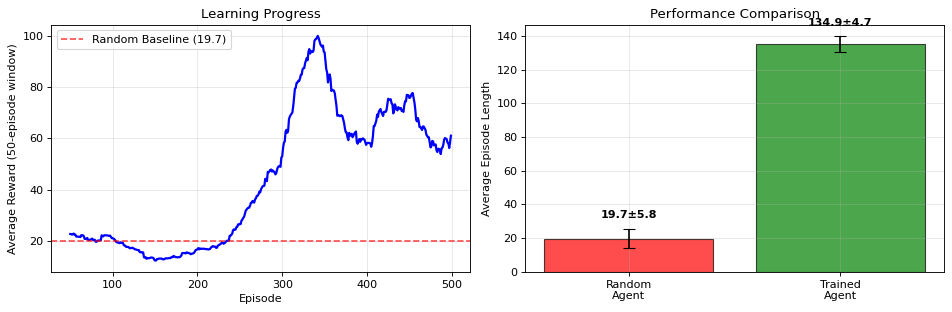

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window_size = 50
if len(training_rewards) >= window_size:
    moving_avg = []
    for i in range(window_size, len(training_rewards)):
        moving_avg.append(np.mean(training_rewards[i-window_size:i]))
    
    plt.plot(range(window_size, len(training_rewards)), moving_avg, 'b-', linewidth=2)
    plt.axhline(y=random_avg, color='red', linestyle='--', alpha=0.7,
               label=f'Random Baseline ({random_avg:.1f})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (50-episode window)')
    plt.title('Learning Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
agents = ['Random\nAgent', 'Trained\nAgent']
means = [random_avg, trained_avg]
stds = [random_std, trained_std]

bars = plt.bar(agents, means, yerr=stds, capsize=5,
               color=['red', 'green'], alpha=0.7, edgecolor='black')
plt.ylabel('Average Episode Length')
plt.title('Performance Comparison')
plt.grid(True, alpha=0.3)

# 막대 위에 수치 표시
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 5,
             f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

env.close()

### 🚀 최신 알고리즘 발전

DQN 계열
- Rainbow DQN: 여러 DQN 개선 기법의 통합
- Double DQN
- Dueling DQN
- Prioritized Experience Replay
- Noisy Networks
- Categorical DQN
- Multi-step Learning

### 실무 팁

#### 하이퍼파라미터 튜닝

중요한 하이퍼파라미터들
- learning_rate = [1e-4, 3e-4, 1e-3] -> 가장 중요! 너무 크면 불안정, 너무 작으면 느린 수렴
- gamma = [0.95, 0.99, 0.999]        -> 환경에 따라 조정
- network_size = [64, 128, 256]      -> 문제 복잡도에 맞게, 과소적합 vs 과적합의 균형
- 배치 크기                           -> 메모리 효율성과 학습 안정성
- replay_buffer_size                  -> 경험 재생 버퍼 크기, 너무 작으면 경험 다양성 부족, 너무 크면 메모리 부담
- epsilon_decay                       -> 탐험 감소 속도, 균형 잡힌 탐험과 활용 필수

#### 재현 가능한 실험
시드 고정으로 재현성 확보
- torch.manual_seed(42)
- np.random.seed(42)
- random.seed(42)

### ✓ 실습 성과:
- CartPole 환경에서 3가지 알고리즘 구현
- PyTorch 기반 신경망 구조 이해
- 각 방법의 학습 특성과 성능 비교
- 하이퍼파라미터 영향도 분석